In [1]:
using JuMP
using HiGHS
using MarketData
using Statistics
using Plots
using Random
using LinearAlgebra
using StatsPlots
using Distributions

In [2]:
function load_data(stocks::Array{String}, years::Int64)
    output = Array{Float64}[]
    t = Dates.now()
    period = YahooOpt(period1 = t - Year(years), period2 = t)
    for stock in stocks
        data = yahoo(stock, period)
        value = (values(data["High"]) + values(data["Low"]))/2;
        push!(output, value)
    end
    return hcat(output...)
end

function evaluate_factor(data::Matrix{Float64})
    m, n = size(data) 
    factor = zeros(m-1,n)
    mean = zeros(n)

    for i in 1:m-1
        factor[i,:] = (data[i+1,:] - (data[i,:])) ./ (data[i,:])
    end
    return factor
end

data = load_data(["PETR4.SA", "VALE3.SA", "AZUL4.SA", "BPAC11.SA", "ABEV3.SA"], 1);
factor = evaluate_factor(data);

In [3]:
m, n = size(factor)
mu = vec(mean(factor, dims=1));
Sigma = cov(factor);
sigma = sqrt.(diag(Sigma));

## 1) For a fixed x (arbitrarily chosen by you), implement the inner minimization problem. Then, formulate and implement the dual to show that the optimal values are the same (for the fixed x).

$\begin{align}
& \min r^Tx \\
&\sum_{i=1}^N z_i = \Gamma &:λ\\ 
& r_i - \mu_i \le z_i \sigma_i, &:π^1_i \quad &\forall i = 1,\ldots,N \\
& \mu_i - r_i \le z_i \sigma_i, &:π^2_i \quad &\forall i = 1,\ldots,N \\
& z_i \leq 1 &:β_i \quad &\forall i = 1,\ldots,N \\
& z_i \geq 0 & &\forall i = 1,\ldots,N \\
&r \in \mathbb{R}^n
\end{align}$

In [4]:
function primal(x, Gamma, factor)

    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)

    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, 0 <= z[1:n])
    @variable(model, r[1:n])

    @constraint(model, lambda, sum(z) == Gamma)
    @constraint(model, pi1[i in 1:n], r[i] - mu[i] <=  z[i] * sigma[i])
    @constraint(model, pi2[i in 1:n], mu[i] - r[i] <=  z[i] * sigma[i])
    @constraint(model, beta[i in 1:n], z[i] <= 1)

    @objective(model, Min, r'x)
    optimize!(model)
    return objective_value(model)
end

primal (generic function with 1 method)

$\begin{align}
& \min λΓ + \sum_{i=1}^N \beta_i + μ^T(π^1 - π^2) \\
& λ^T\mathbf{1} - \sigma (π^1 + π^2) + β \leq 0 \\ 
& π^1 - π^2 = x \\
& β_i ≤ 0 \quad &\forall i = 1,\ldots,N \\
& π^1_i ≤ 0 \quad &\forall i = 1,\ldots,N \\
& π^2_i ≤ 0 \quad &\forall i = 1,\ldots,N \\
& λ \in \mathbb{R} 
\end{align}$

In [5]:
function dual(x, Gamma, factor)
    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)

    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, lambda)
    @variable(model, beta[1:n] <= 0)
    @variable(model, pi1[1:n] <= 0)
    @variable(model, pi2[1:n] <= 0)

    @constraint(model, z[i = 1:n], lambda - sigma[i] * (pi1[i] + pi2[i]) + beta[i] <= 0)
    @constraint(model, r[i = 1:n], pi1[i] - pi2[i] == x[i])
        
    @objective(model, Max, lambda*Gamma + sum(beta) + dot(mu,(pi1 - pi2)))
    optimize!(model)
    return objective_value(model)
end

dual (generic function with 1 method)

In [6]:
x = (1/n)*ones(n)
Gamma = 1
@show primal(x, Gamma, factor);
@show dual(x, Gamma, factor);

primal(x, Gamma, factor) = -0.00718462930210795
dual(x, Gamma, factor) = -0.0071846293021079494


## 2) Formulate and implement the single level formulation for the robust portfolio optimization and perform a sensitivity analysis on the uncertainty budget $\Gamma$. 

In [7]:
function first_level(Γ)
    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)

    model = Model(HiGHS.Optimizer)
    set_silent(model)
        
    @variable(model, lambda)
    @variable(model, x[1:n] >= 0)
    @variable(model, beta[1:n] <= 0)
    @variable(model, pi1[1:n] <= 0)
    @variable(model, pi2[1:n] <= 0)

    @constraint(model, w, sum(x) == 1)
    @constraint(model, z[i = 1:n], lambda - sigma[i] * (pi1[i] + pi2[i]) + beta[i] <= 0)
    @constraint(model, r[i = 1:n], pi1[i] - pi2[i] == x[i])

    @objective(model, Max, lambda*Γ + sum(beta) + dot(mu,(pi1 .- pi2)))
    optimize!(model)
    return model
end

first_level (generic function with 1 method)

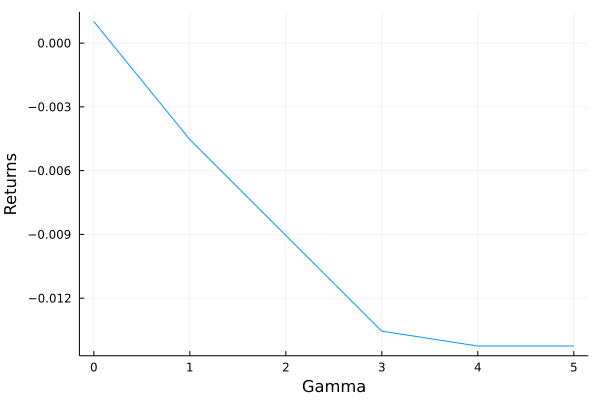

In [8]:
Gammas = collect(0:5)
models = first_level.(Gammas)
obj_values = objective_value.(models)
plot(Gammas,obj_values,xlabel="Gamma",ylabel="Returns",legend=false)

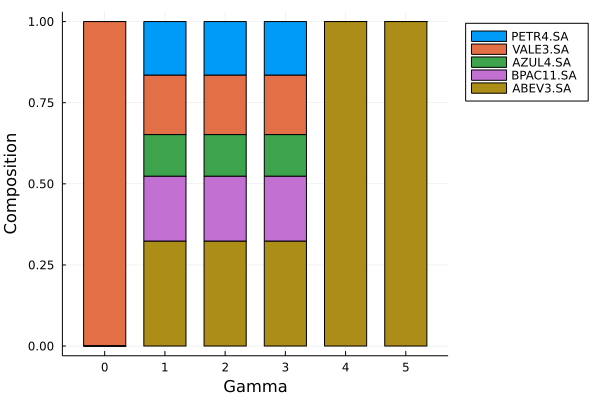

In [9]:
xs = Matrix(hcat([value.(model[:x]) for model in models]...))';
groupedbar(xs, bar_position = :stack, bar_width=0.7, xticks=(1:n+1,Gammas), legend=:outertopright, xlabel="Gamma", ylabel="Composition", label=permutedims(["PETR4.SA", "VALE3.SA", "AZUL4.SA", "BPAC11.SA", "ABEV3.SA"]))

## 3)As a post-optimization analysis, for different $\Gamma$, assume a probability distribution for the returns and compute (via simulation) the probability of the simulated portfolio return be smaller than the optimal value of the problem.

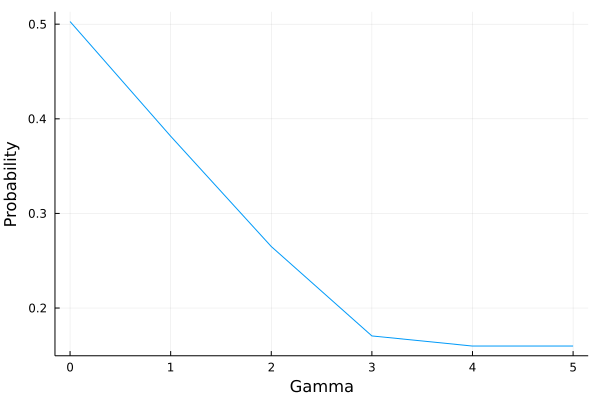

In [17]:
r_dist = MvNormal(mu, Sigma);
N_samples = 10000
r_out_of_sample = rand(r_dist, N_samples);
return_by_gamma_scenario = xs*r_out_of_sample;
estimated_prob_portfolios = sum(return_by_gamma_scenario .< obj_values,dims=2)/N_samples
plot(Gammas,estimated_prob_portfolios,xlabel="Gamma",ylabel="Probability",legend=false)

## 4) Implement a Data-Driven Robust portfolio optimization $\max_{x \in \mathcal{X}} \min_{\tilde{r} \in \mathcal{U}} \sum_{i=1}^N \tilde{r}_i x_i$, where the uncertainty set is given by all possible convex combinations of historical data points. Show a sensitivity analysis over the number of past days considered.

$\begin{align}
& \min r^Tx \\
&\sum_{t=1}^T \theta_t = 1 &:λ\\ 
& \sum_{t=1}^T \theta_t p_t = r &:π \\
& \theta_t \leq 1 &:β \\
& \theta_t \geq 0 \\
& r \in \mathbb{R}
\end{align}$

In [18]:
function primal(T,x,factor)
    
    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)
    
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    @variable(model, theta[1:T] >= 0)
    @variable(model, r[1:n])

    @constraint(model, beta[t in 1:T], theta[t] <= 1)
    @constraint(model, pi[i in 1:n], sum(theta[t]*factor[m-T+t,i] for t in 1:T) == r[i])
    @constraint(model, lambda, sum(theta) == 1)
    
    @objective(model, Min, r'x)
    optimize!(model)

    return objective_value(model)
end

primal (generic function with 1 method)

$\begin{align*}
& \min λ + \sum_{t=1}^T \beta_t \\
& λ^T\mathbf{1} + β^T \leq xp_t \\
& β ≤ 0 \\
& λ \in \mathbb{R} 
\end{align*}$

In [19]:
function dual(T,x,factor)

    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)
    
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    @variable(model, beta[1:T] <= 0)
    @variable(model, lambda)
    @constraint(model, theta[t in 1:T], lambda + beta[t] <= sum(factor[m-T+t,i]*x[i] for i in 1:n))
    @objective(model, Max, sum(beta) + lambda)
    optimize!(model)

    return objective_value(model)
end

dual (generic function with 1 method)

In [20]:
T = 10;
@show primal(T,x,factor);
@show dual(T,x,factor);

primal(T, x, factor) = -0.04621493522312006
dual(T, x, factor) = -0.04621493522312006


In [21]:
function first_level(T)
    
    mu = vec(mean(factor, dims=1))
    Sigma = cov(factor)
    sigma = diag(Sigma).^(1/2)
    m, n = size(factor)
    
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    @variable(model, beta[1:T] <= 0)
    @variable(model, x[1:n] >= 0)
    @variable(model, lambda)
    
    @constraint(model, theta[t in 1:T], lambda + beta[t] <= sum(factor[m-T+t,i]*x[i] for i in 1:n))
    @constraint(model, w, sum(x) == 1)
    
    @objective(model, Max, sum(beta) + lambda)
    optimize!(model)

    return model
end

first_level (generic function with 1 method)

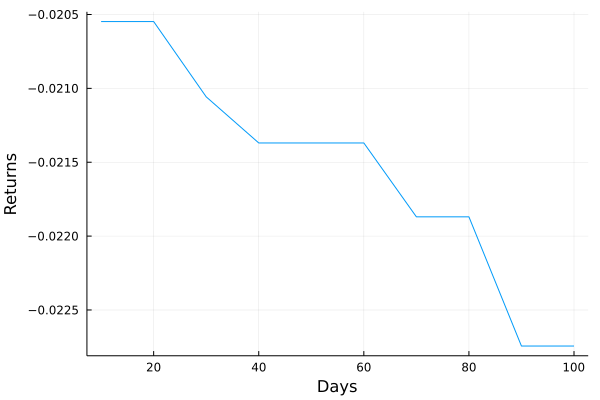

In [22]:
Ts = collect(10:10:100)
models = first_level.(Ts)
obj_values = objective_value.(models)
plot(Ts,obj_values,xlabel="Days",ylabel="Returns",legend=false)

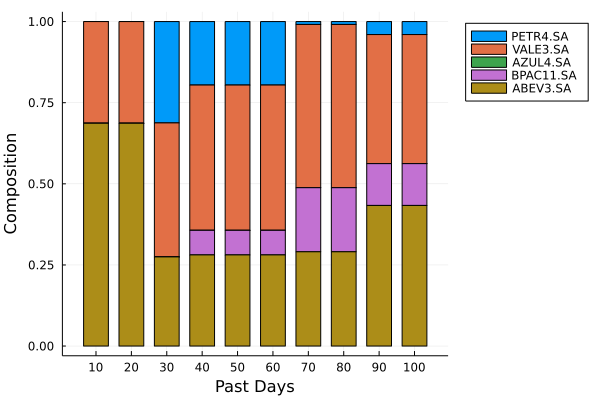

In [23]:
xs = Matrix(hcat([value.(model[:x]) for model in models]...))';
groupedbar(xs, bar_position = :stack, bar_width=0.7, xticks=(1:length(Ts),Ts), legend=:outertopright, xlabel="Past Days", ylabel="Composition", label=permutedims(["PETR4.SA", "VALE3.SA", "AZUL4.SA", "BPAC11.SA", "ABEV3.SA"]))